In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

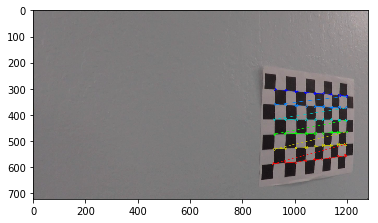

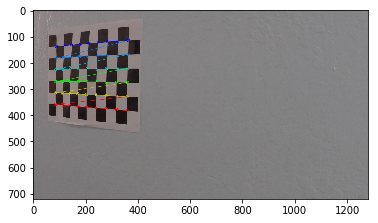

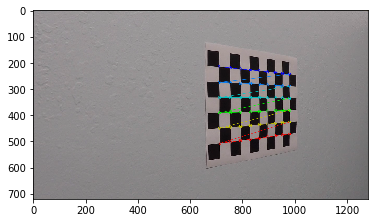

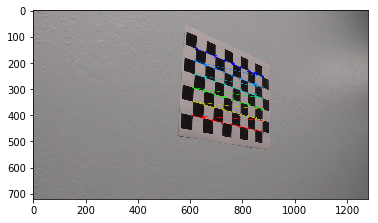

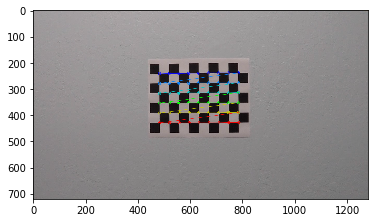

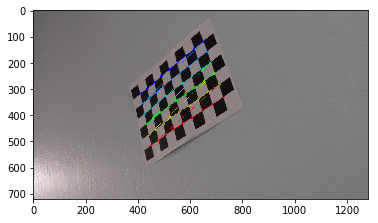

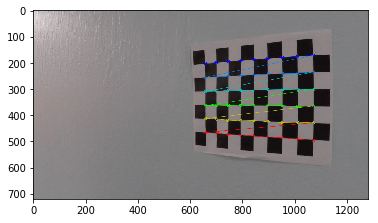

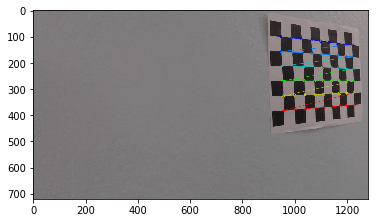

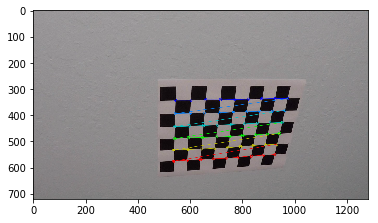

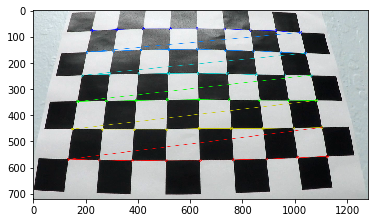

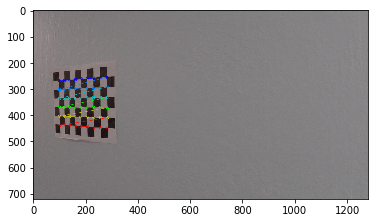

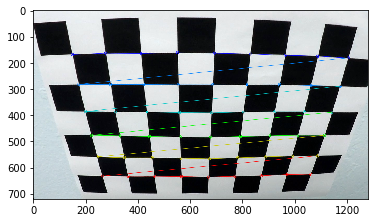

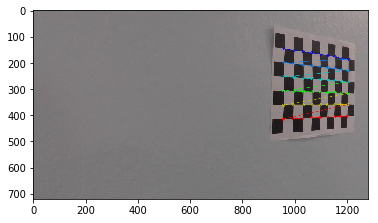

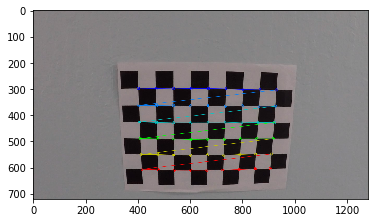

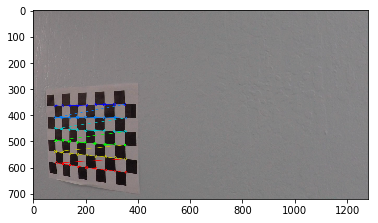

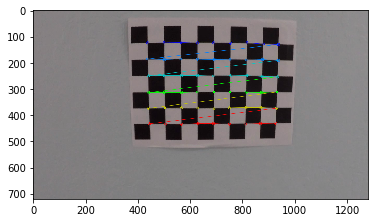

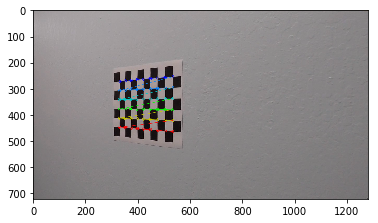

In [2]:
#camera calibration
nx = 9
ny = 6
objpoints, imagepoints = [], []
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
calibration_images = glob.glob('camera_cal/calibration*')

for i, filename in enumerate(calibration_images):
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        objpoints.append(objp)
        imagepoints.append(corners)
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.figure()
        plt.imshow(img)
plt.show()

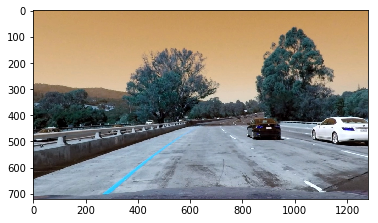

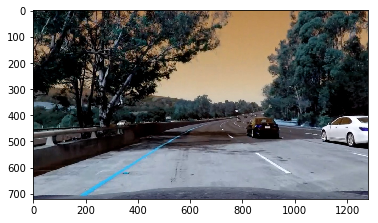

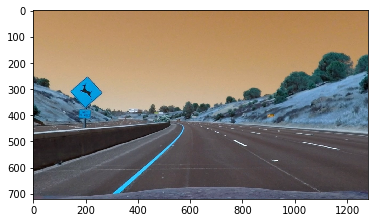

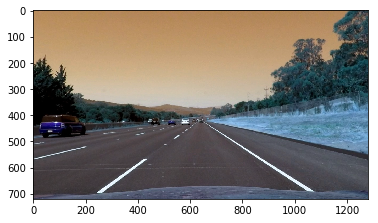

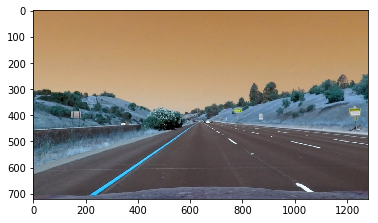

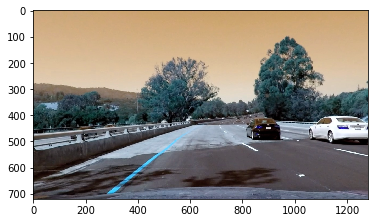

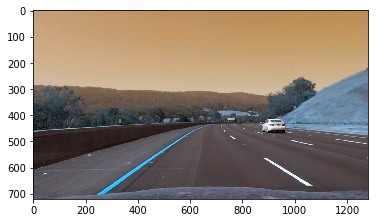

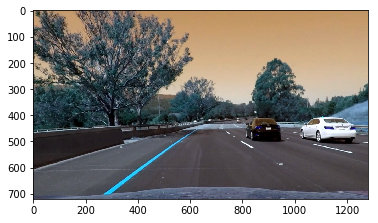

In [3]:
test_image = cv2.imread('test_images/straight_lines1.jpg')
test_images = glob.glob('test_images/*')
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imagepoints, test_image.shape[:2], None, None)
images = []
for i, filename in enumerate(test_images):
    img = cv2.imread(filename)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    images.append(dst)
    plt.figure()
    plt.imshow(dst)
plt.show()

In [4]:
#useful methods for image processing
def show_gray(images):
    for im in images:
        plt.figure()
        plt.imshow(im, cmap='gray')

def show(images):
    for im in images:
        plt.figure()
        plt.imshow(im)

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray=img
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0) if orient == 'x' else cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary = np.zeros_like(scaled)
    binary[(scaled <= thresh_max) & (scaled >= thresh_min)] = 1
    return binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0,255)):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary = np.zeros_like(scaled)
    binary[(scaled <= mag_thresh[1]) & (scaled >= mag_thresh[0])] = 1
    return binary

'''
Direction of the gradient is computed with arctan(sobely/sobelx)
'''
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    binary = np.zeros_like(direction)
    binary[(direction <= thresh[1]) & (direction >= thresh[0])] = 1
    return binary

def s_select_thresh(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    binary_output = np.zeros_like(s)
    binary_output[(s <= thresh[1]) & (s > thresh[0])] = 1
    return binary_output

def s_select(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    return s

In [28]:
thresholded_images = []
#for image in images:
def threshold(image):
    hls = s_select_thresh(image, (170, 255))
    s = s_select(image)
    sobelx = abs_sobel_thresh(s, 'x', 20, 100)
    #sobely = abs_sobel_thresh(s, 'y', 20, 100)
    #sobelxy = mag_thresh(s, 3, (20, 50))
    dr = dir_threshold(s, 3,(0.7, 1.3))
    combined = np.zeros_like(s)
    combined[((dr == 1) & (sobelx == 1)) | (hls == 1)] = 1
    #thresholded_images.append(combined)
    return combined
    #show_gray([combined])
plt.show()

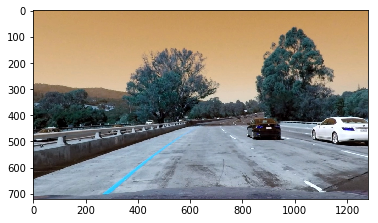

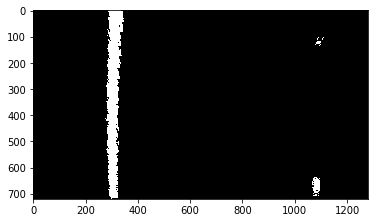

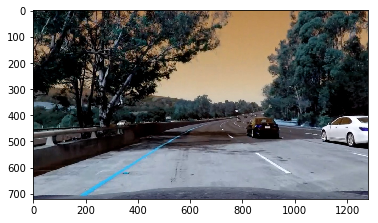

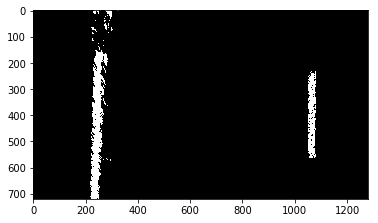

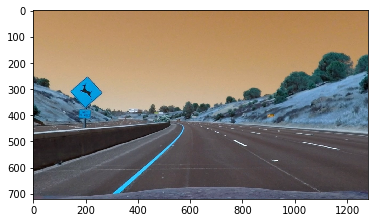

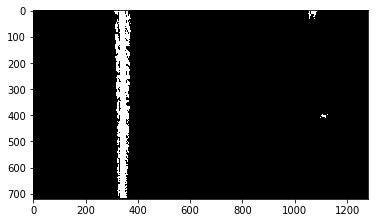

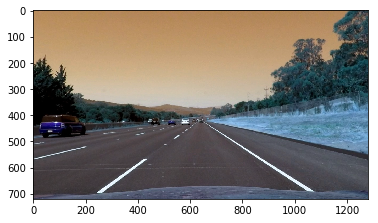

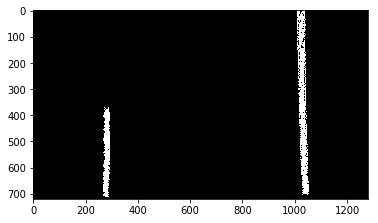

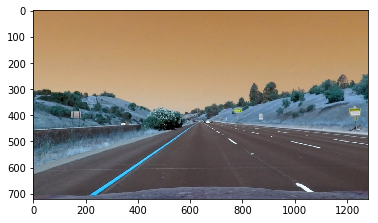

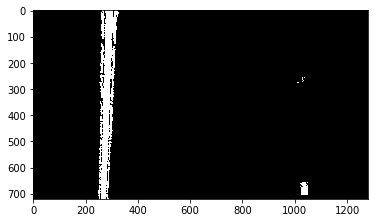

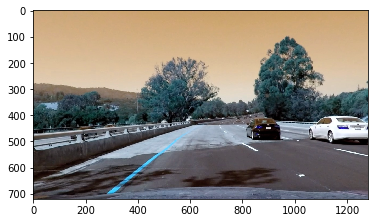

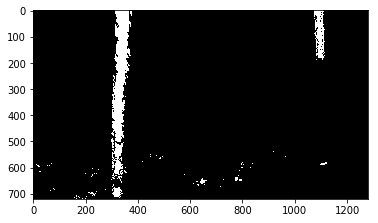

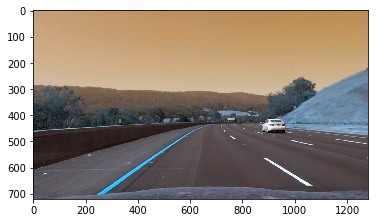

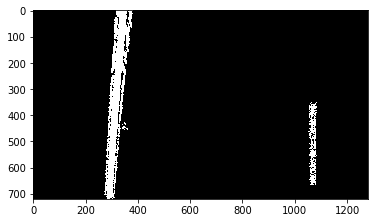

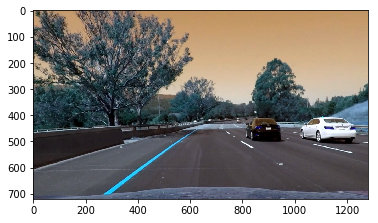

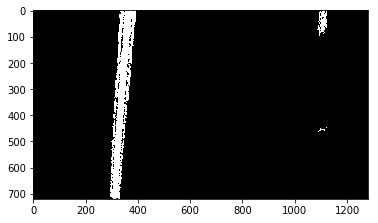

In [6]:
#perspective transform
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

transformed_images = []

for i, image in enumerate(thresholded_images):
    imshape = image.shape
    a = (210,imshape[0]-50)
    b = ((imshape[1]/2)-180, 520)
    c = ((imshape[1]/2)+180, 520)
    d = (imshape[1]-210,imshape[0]-50)
    src = np.array([[a, b, c, d]], dtype=np.float32)
    #selected = region_of_interest(image, src)
    offsetx = 200
    offsety = 50
    dst = np.float32([[offsetx,imshape[0]-offsety], 
                      [offsetx,offsety], 
                      [imshape[1]-offsetx, offsety], 
                      [imshape[1]-offsetx, imshape[0]-offsety]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    transformed_images.append(warped)
    plt.figure()
    plt.imshow(images[i])
    plt.figure()
    plt.imshow(warped, cmap='gray')
plt.show()

In [ ]:
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
	    l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
	    r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
	    # Add graphic points from window mask here to total pixels found 
	    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
	    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

In [36]:
#for binary_warped in transformed_images:
def hist(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 30
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    #leftx = nonzerox[left_lane_inds]
    #lefty = nonzeroy[left_lane_inds] 
    #rightx = nonzerox[right_lane_inds]
    #righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    #left_fit = np.polyfit(lefty, leftx, 2)
    #right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    #ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    '''
    plt.figure()
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    '''
    return out_img
plt.show()

In [37]:
imshape = image.shape
a = (210,imshape[0]-50)
b = ((imshape[1]/2)-180, 520)
c = ((imshape[1]/2)+180, 520)
d = (imshape[1]-210,imshape[0]-50)
src = np.array([[a, b, c, d]], dtype=np.float32)
#selected = region_of_interest(image, src)
offsetx = 200
offsety = 50
dst = np.float32([[offsetx,imshape[0]-offsety], 
                  [offsetx,offsety], 
                  [imshape[1]-offsetx, offsety], 
                  [imshape[1]-offsetx, imshape[0]-offsety]])
M = cv2.getPerspectiveTransform(src, dst)
def process_image(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    image = threshold(dst)
    imshape = image.shape
    warped = cv2.warpPerspective(image, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    return hist(warped)

In [38]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'out1.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video out1.mp4
[MoviePy] Writing video out1.mp4



100%|█████████▉| 1260/1261 [04:26<00:00,  5.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out1.mp4 

CPU times: user 4min 49s, sys: 20.1 s, total: 5min 9s
Wall time: 4min 26s
